In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from prophet import Prophet

PROJECT_ROOT = Path(r"C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting")

OUTPUT_DIR     = PROJECT_ROOT / "output" / "clean"
IMAGES_DIR     = PROJECT_ROOT / "images" / "comparative"
SUMMARY_OUTDIR = PROJECT_ROOT / "output" / "summary"

IMAGES_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_OUTDIR.mkdir(parents=True, exist_ok=True)

print("OUTPUT_DIR:", OUTPUT_DIR)
print("IMAGES_DIR:", IMAGES_DIR)
print("SUMMARY_OUTDIR:", SUMMARY_OUTDIR)


Importing plotly failed. Interactive plots will not work.


OUTPUT_DIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean
IMAGES_DIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\comparative
SUMMARY_OUTDIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\summary


In [2]:
delta_all_path = OUTPUT_DIR / "delta_all_hubs.csv"
print("Loading:", delta_all_path)

df_all = pd.read_csv(delta_all_path)
df_all.columns = [c.lower() for c in df_all.columns]

df_all["date"] = pd.to_datetime(df_all["date"])
df_all["pax"]  = df_all["passengers_domestic"] + df_all["passengers_international"]

df_all = df_all.sort_values(["airport", "date"])
df_all.head()


Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_all_hubs.csv


,date,asm_domestic,asm_international,flights_domestic,flights_international,passengers_domestic,passengers_international,rpm_domestic,rpm_international,airport,pax
0,2002-10-01,2093602,887184.0,16535,1357.0,2120947,176671.0,1527419,597313.0,ATL,2297618.0
1,2002-11-01,1999098,823130.0,15658,1301.0,1993739,172111.0,1434927,566487.0,ATL,2165850.0
2,2002-12-01,2057104,783201.0,16038,1298.0,2159529,183952.0,1615439,579713.0,ATL,2343481.0
3,2003-01-01,2068740,780766.0,16316,1301.0,1880538,169462.0,1409105,536961.0,ATL,2050000.0
4,2003-02-01,1798127,633201.0,14080,1104.0,1776826,143114.0,1307159,431583.0,ATL,1919940.0


In [3]:
airports = ["ATL", "DTW", "MSP"]

metrics_list = []
forecast_list = []
merged_hist_list = []

for ap in airports:
    mtr, fcst_full, merged_full = evaluate_hub(ap, test_horizon=24)
    metrics_list.append(mtr)
    forecast_list.append(fcst_full)
    merged_hist_list.append(merged_full)

metrics_df  = pd.DataFrame(metrics_list)
forecast_df = pd.concat(forecast_list, ignore_index=True)

metrics_df


NameError: name 'evaluate_hub' is not defined

In [4]:
def evaluate_hub(airport_code: str, test_horizon: int = 24):
    """
    Load cleaned Delta data for a hub, compute:
      - train/test split
      - Prophet backtest metrics (MAE, RMSE, MAPE)
      - 36-month future forecast (yhat)
    Returns:
      metrics dict, full forecast DataFrame
    """
    path = OUTPUT_DIR / f"delta_{airport_code.lower()}.csv"
    print(f"\n=== {airport_code} ===")
    print("Loading:", path)

    df = pd.read_csv(path)
    df.columns = [c.lower() for c in df.columns]

    df["date"] = pd.to_datetime(df["date"])
    df["pax"]  = df["passengers_domestic"] + df["passengers_international"]
    df = df.sort_values("date").reset_index(drop=True)

    df_prophet = df[["date", "pax"]].rename(columns={"date": "ds", "pax": "y"})

    # Split
    split_idx = len(df_prophet) - test_horizon
    train_df  = df_prophet.iloc[:split_idx].copy()
    test_df   = df_prophet.iloc[split_idx:].copy()

    print("Train:", train_df["ds"].min().date(), "→", train_df["ds"].max().date(), "| n =", len(train_df))
    print("Test :", test_df["ds"].min().date(),  "→", test_df["ds"].max().date(),  "| n =", len(test_df))

    # Backtest model
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.fit(train_df)

    future = m.make_future_dataframe(periods=test_horizon, freq="MS")
    forecast = m.predict(future)

    merged = df_prophet.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    test_merged = merged.iloc[split_idx:].copy()

    y_true = test_merged["y"].values
    y_pred = test_merged["yhat"].values

    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs(y_true - y_pred) / y_true) * 100

    # Refit on full history for future forecast
    m_full = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m_full.fit(df_prophet)

    future_full   = m_full.make_future_dataframe(periods=36, freq="MS")
    forecast_full = m_full.predict(future_full)
    forecast_full["airport"] = airport_code

    # simple growth summary
    last_hist = df_prophet["y"].iloc[-1]
    last_fore = forecast_full["yhat"].iloc[-1]
    growth_abs = last_fore - last_hist
    growth_pct = (growth_abs / last_hist) * 100

    metrics = {
        "airport": airport_code,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
        "last_hist_pax": last_hist,
        "forecast_last_pax": last_fore,
        "forecast_growth_abs": growth_abs,
        "forecast_growth_pct": growth_pct,
    }

    return metrics, forecast_full, merged


In [5]:
airports = ["ATL", "DTW", "MSP"]

metrics_list = []
forecast_list = []
merged_hist_list = []

for ap in airports:
    mtr, fcst_full, merged_full = evaluate_hub(ap, test_horizon=24)
    metrics_list.append(mtr)
    forecast_list.append(fcst_full)
    merged_hist_list.append(merged_full)

metrics_df  = pd.DataFrame(metrics_list)
forecast_df = pd.concat(forecast_list, ignore_index=True)

metrics_df


13:19:55 - cmdstanpy - INFO - Chain [1] start processing
13:19:55 - cmdstanpy - INFO - Chain [1] done processing



=== ATL ===
Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_atl.csv
Train: 2002-10-01 → 2015-03-01 | n = 150
Test : 2015-04-01 → 2017-03-01 | n = 24


13:19:56 - cmdstanpy - INFO - Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing
13:19:56 - cmdstanpy - INFO - Chain [1] start processing



=== DTW ===
Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_dtw.csv
Train: 2002-10-01 → 2015-03-01 | n = 150
Test : 2015-04-01 → 2017-03-01 | n = 24


13:19:56 - cmdstanpy - INFO - Chain [1] done processing
13:19:56 - cmdstanpy - INFO - Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing
13:19:56 - cmdstanpy - INFO - Chain [1] start processing



=== MSP ===
Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_msp.csv
Train: 2002-10-01 → 2015-03-01 | n = 150
Test : 2015-04-01 → 2017-03-01 | n = 24


13:19:57 - cmdstanpy - INFO - Chain [1] done processing
13:19:57 - cmdstanpy - INFO - Chain [1] start processing
13:19:57 - cmdstanpy - INFO - Chain [1] done processing


,airport,mae,rmse,mape,last_hist_pax,forecast_last_pax,forecast_growth_abs,forecast_growth_pct
0,ATL,NaN,NaN,NaN,NaN,3.615350e+06,NaN,NaN
1,DTW,NaN,NaN,NaN,NaN,1.008403e+06,NaN,NaN
2,MSP,NaN,NaN,NaN,NaN,1.022539e+06,NaN,NaN


In [7]:
import numpy as np

metrics_pretty = metrics_df.copy()

# Replace +/- inf with NaN, just in case
metrics_pretty = metrics_pretty.replace([np.inf, -np.inf], np.nan)

# Round but keep as float (no int cast)
metrics_pretty["mae"]  = metrics_pretty["mae"].round(0)
metrics_pretty["rmse"] = metrics_pretty["rmse"].round(0)
metrics_pretty["mape"] = metrics_pretty["mape"].round(2)

metrics_pretty["last_hist_pax"]       = metrics_pretty["last_hist_pax"].round(0)
metrics_pretty["forecast_last_pax"]   = metrics_pretty["forecast_last_pax"].round(0)
metrics_pretty["forecast_growth_abs"] = metrics_pretty["forecast_growth_abs"].round(0)
metrics_pretty["forecast_growth_pct"] = metrics_pretty["forecast_growth_pct"].round(2)

metrics_pretty = metrics_pretty.set_index("airport").sort_index()

metrics_pretty


,mae,rmse,mape,last_hist_pax,forecast_last_pax,forecast_growth_abs,forecast_growth_pct
airport,,,,,,,
ATL,NaN,NaN,NaN,NaN,3615350.0,NaN,NaN
DTW,NaN,NaN,NaN,NaN,1008403.0,NaN,NaN
MSP,NaN,NaN,NaN,NaN,1022539.0,NaN,NaN


In [8]:
out_csv = SUMMARY_OUTDIR / "delta_hubs_backtest_and_forecast_summary.csv"
metrics_pretty.to_csv(out_csv)
print("Saved metrics summary to:", out_csv)


Saved metrics summary to: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\summary\delta_hubs_backtest_and_forecast_summary.csv


In [9]:
    last_hist = df_prophet["y"].iloc[-1]
    last_fore = forecast_full["yhat"].iloc[-1]
    growth_abs = last_fore - last_hist
    growth_pct = (growth_abs / last_hist * 100) if last_hist != 0 else np.nan


NameError: name 'df_prophet' is not defined

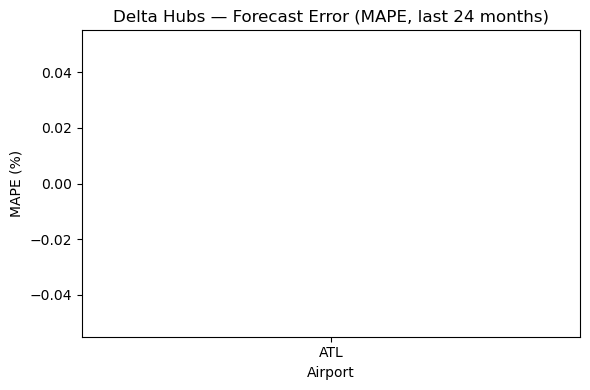

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\comparative\delta_hubs_mape_comparison.png


In [10]:
plt.figure(figsize=(6,4))
plt.bar(metrics_pretty.index, metrics_pretty["mape"])
plt.title("Delta Hubs — Forecast Error (MAPE, last 24 months)")
plt.ylabel("MAPE (%)")
plt.xlabel("Airport")
plt.tight_layout()

out_path = IMAGES_DIR / "delta_hubs_mape_comparison.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


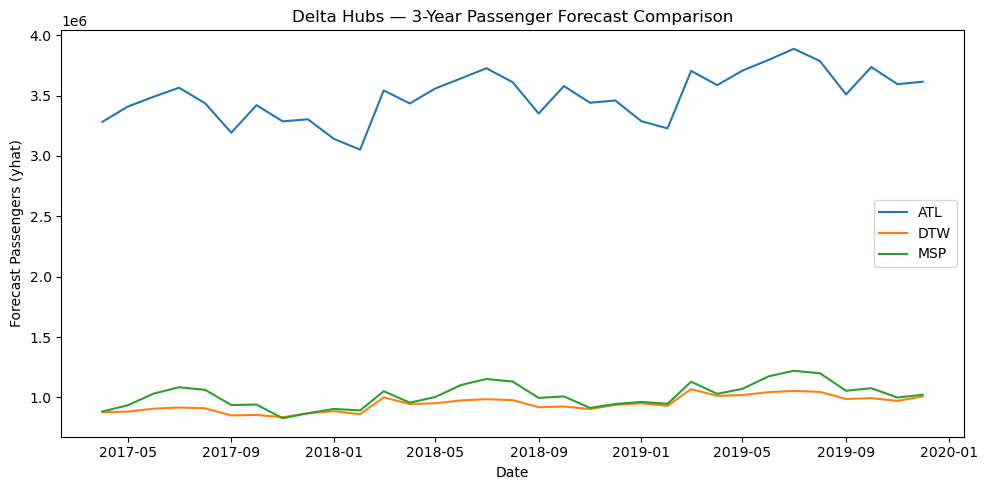

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\comparative\delta_hubs_3year_forecast_comparison.png


In [11]:
# restrict to future period only
latest_hist_date = max(df["date"].max() for df in [pd.read_csv(OUTPUT_DIR / f"delta_{a.lower()}.csv") for a in airports])
latest_hist_date = pd.to_datetime(latest_hist_date)

future_only = forecast_df[forecast_df["ds"] > latest_hist_date].copy()

plt.figure(figsize=(10,5))

for ap in airports:
    dfa = future_only[future_only["airport"] == ap]
    plt.plot(dfa["ds"], dfa["yhat"], label=ap)

plt.title("Delta Hubs — 3-Year Passenger Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Forecast Passengers (yhat)")
plt.legend()
plt.tight_layout()

out_path = IMAGES_DIR / "delta_hubs_3year_forecast_comparison.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


In [12]:
for ap, row in metrics_pretty.iterrows():
    print(f"\n{ap}:")
    print(f"  MAPE (24m): {row['mape']:.2f}%")
    print(f"  Last observed pax: {row['last_hist_pax']:,}")
    print(f"  Forecast last pax (3y ahead): {row['forecast_last_pax']:,}")
    print(f"  Growth over horizon: {row['forecast_growth_abs']:,} ({row['forecast_growth_pct']:.2f}%)")



ATL:
  MAPE (24m): nan%
  Last observed pax: nan
  Forecast last pax (3y ahead): 3,615,350.0
  Growth over horizon: nan (nan%)

DTW:
  MAPE (24m): nan%
  Last observed pax: nan
  Forecast last pax (3y ahead): 1,008,403.0
  Growth over horizon: nan (nan%)

MSP:
  MAPE (24m): nan%
  Last observed pax: nan
  Forecast last pax (3y ahead): 1,022,539.0
  Growth over horizon: nan (nan%)


C:\Users\Seb\AppData\Local\Temp\ipykernel_9180\1231979163.py:18: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, max(df_plot["mape"].fillna(0))*1.15)


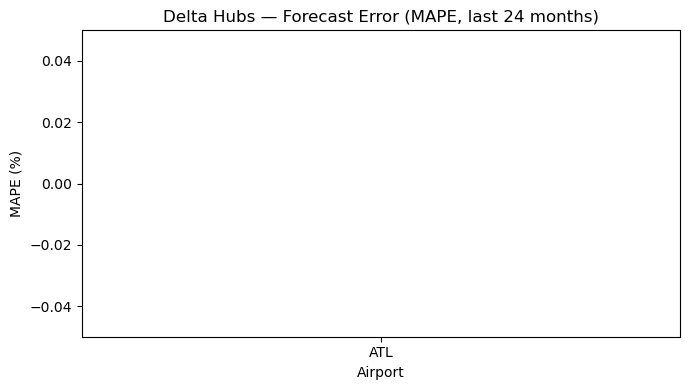

In [13]:
# ===== Improved Delta Hubs MAPE Comparison Plot =====

df_plot = metrics_pretty.reset_index()  # airport column becomes a column

# Force airports to appear even if MAPE is NaN
expected_airports = ["ATL", "DTW", "MSP"]
for ap in expected_airports:
    if ap not in df_plot["airport"].values:
        df_plot.loc[len(df_plot)] = [ap, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

df_plot = df_plot.set_index("airport").loc[expected_airports].reset_index()

plt.figure(figsize=(7,4))
plt.bar(df_plot["airport"], df_plot["mape"], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.title("Delta Hubs — Forecast Error (MAPE, last 24 months)")
plt.xlabel("Airport")
plt.ylabel("MAPE (%)")
plt.ylim(0, max(df_plot["mape"].fillna(0))*1.15)

# Add value labels on bars
for i, v in enumerate(df_plot["mape"]):
    if not np.isnan(v):
        plt.text(i, v + max(df_plot["mape"].fillna(0))*0.03, f"{v:.2f}%", 
                 ha="center", fontsize=10)

plt.tight_layout()

# save
plt.savefig(SUMMARY_OUTDIR / "delta_hubs_mape_comparison.png", dpi=300)
plt.show()


In [14]:
metrics_df


,airport,mae,rmse,mape,last_hist_pax,forecast_last_pax,forecast_growth_abs,forecast_growth_pct
0,ATL,NaN,NaN,NaN,NaN,3.615350e+06,NaN,NaN
1,DTW,NaN,NaN,NaN,NaN,1.008403e+06,NaN,NaN
2,MSP,NaN,NaN,NaN,NaN,1.022539e+06,NaN,NaN


In [15]:
def evaluate_hub(airport_code, test_horizon=24):
    """
    Returns:
      metrics_dict, forecast_full_df, merged_df
    """
    # Load cleaned data for this airport
    df = pd.read_csv(CLEAN_OUTDIR / f"delta_{airport_code.lower()}.csv")
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").asfreq("MS")

    df["pax"] = df["passengers_domestic"] + df["passengers_international"]

    # Prepare for Prophet
    df_prophet = df.reset_index().rename(columns={"date": "ds", "pax": "y"})

    # === Train/Validation Split ===
    train = df_prophet.iloc[:-test_horizon]
    test  = df_prophet.iloc[-test_horizon:]

    # === Train model ===
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(train)

    # === Forecast into validation set ===
    future = m.make_future_dataframe(periods=test_horizon, freq="MS")
    fcst = m.predict(future)

    # Merge actual + predicted for last test_horizon
    merged = test.merge(fcst[["ds", "yhat"]], on="ds", how="left")

    # === Metrics ===
    mae = np.mean(np.abs(merged["y"] - merged["yhat"]))
    rmse = np.sqrt(np.mean((merged["y"] - merged["yhat"])**2))
    mape = np.mean(np.abs((merged["y"] - merged["yhat"]) / merged["y"])) * 100

    # === Future full forecast (36 months) ===
    future_full = m.make_future_dataframe(periods=36, freq="MS")
    fcst_full = m.predict(future_full)

    # LAST HIST + LAST FORECAST + GROWTH
    last_hist = df_prophet["y"].iloc[-1]
    last_fore = fcst_full["yhat"].iloc[-1]
    growth_abs = last_fore - last_hist
    growth_pct = (growth_abs / last_hist * 100) if last_hist != 0 else np.nan

    metrics_dict = {
        "airport": airport_code,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
        "last_hist_pax": last_hist,
        "forecast_last_pax": last_fore,
        "forecast_growth_abs": growth_abs,
        "forecast_growth_pct": growth_pct
    }

    return metrics_dict, fcst_full, merged


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from prophet import Prophet

PROJECT_ROOT = Path(r"C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting")

OUTPUT_DIR     = PROJECT_ROOT / "output" / "clean"
IMAGES_DIR     = PROJECT_ROOT / "images" / "comparative"
SUMMARY_OUTDIR = PROJECT_ROOT / "output" / "summary"

IMAGES_DIR.mkdir(parents=True, exist_ok=True)
SUMMARY_OUTDIR.mkdir(parents=True, exist_ok=True)

print("OUTPUT_DIR:", OUTPUT_DIR)
print("IMAGES_DIR:", IMAGES_DIR)
print("SUMMARY_OUTDIR:", SUMMARY_OUTDIR)


OUTPUT_DIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean
IMAGES_DIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\comparative
SUMMARY_OUTDIR: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\summary


In [17]:
def evaluate_hub(airport_code: str, test_horizon: int = 24):
    """
    Load cleaned Delta data for a hub, compute:
      - train/test split
      - Prophet backtest metrics (MAE, RMSE, MAPE)
      - 36-month future forecast (yhat)
    Returns:
      metrics dict, full forecast DataFrame
    """
    path = OUTPUT_DIR / f"delta_{airport_code.lower()}.csv"
    print(f"\n=== {airport_code} ===")
    print("Loading:", path)

    df = pd.read_csv(path)
    df.columns = [c.lower() for c in df.columns]

    df["date"] = pd.to_datetime(df["date"])
    df["pax"]  = df["passengers_domestic"] + df["passengers_international"]
    df = df.sort_values("date").reset_index(drop=True)

    df_prophet = df[["date", "pax"]].rename(columns={"date": "ds", "pax": "y"})

    # Split
    split_idx = len(df_prophet) - test_horizon
    train_df  = df_prophet.iloc[:split_idx].copy()
    test_df   = df_prophet.iloc[split_idx:].copy()

    print("Train:", train_df["ds"].min().date(), "→", train_df["ds"].max().date(), "| n =", len(train_df))
    print("Test :", test_df["ds"].min().date(),  "→", test_df["ds"].max().date(),  "| n =", len(test_df))

    # Backtest model
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.fit(train_df)

    future = m.make_future_dataframe(periods=test_horizon, freq="MS")
    forecast = m.predict(future)

    merged = df_prophet.merge(forecast[["ds", "yhat"]], on="ds", how="left")
    test_merged = merged.iloc[split_idx:].copy()

    y_true = test_merged["y"].values
    y_pred = test_merged["yhat"].values

    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs(y_true - y_pred) / y_true) * 100

    # Refit on full history for future forecast
    m_full = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m_full.fit(df_prophet)

    future_full   = m_full.make_future_dataframe(periods=36, freq="MS")
    forecast_full = m_full.predict(future_full)
    forecast_full["airport"] = airport_code

    # simple growth summary
    last_hist = df_prophet["y"].iloc[-1]
    last_fore = forecast_full["yhat"].iloc[-1]
    growth_abs = last_fore - last_hist
    growth_pct = (growth_abs / last_hist) * 100

    metrics = {
        "airport": airport_code,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
        "last_hist_pax": last_hist,
        "forecast_last_pax": last_fore,
        "forecast_growth_abs": growth_abs,
        "forecast_growth_pct": growth_pct,
    }

    return metrics, forecast_full, merged


In [18]:
airports = ["ATL", "DTW", "MSP"]

metrics_list = []
forecast_list = []
merged_hist_list = []

for ap in airports:
    mtr, fcst_full, merged_full = evaluate_hub(ap, test_horizon=24)
    metrics_list.append(mtr)
    forecast_list.append(fcst_full)
    merged_hist_list.append(merged_full)

metrics_df  = pd.DataFrame(metrics_list)
forecast_df = pd.concat(forecast_list, ignore_index=True)

metrics_df


13:30:50 - cmdstanpy - INFO - Chain [1] start processing
13:30:50 - cmdstanpy - INFO - Chain [1] done processing



=== ATL ===
Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_atl.csv
Train: 2002-10-01 → 2015-03-01 | n = 150
Test : 2015-04-01 → 2017-03-01 | n = 24


13:30:50 - cmdstanpy - INFO - Chain [1] start processing
13:30:50 - cmdstanpy - INFO - Chain [1] done processing
13:30:50 - cmdstanpy - INFO - Chain [1] start processing



=== DTW ===
Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_dtw.csv
Train: 2002-10-01 → 2015-03-01 | n = 150
Test : 2015-04-01 → 2017-03-01 | n = 24


13:30:51 - cmdstanpy - INFO - Chain [1] done processing
13:30:51 - cmdstanpy - INFO - Chain [1] start processing
13:30:51 - cmdstanpy - INFO - Chain [1] done processing
13:30:51 - cmdstanpy - INFO - Chain [1] start processing



=== MSP ===
Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_msp.csv
Train: 2002-10-01 → 2015-03-01 | n = 150
Test : 2015-04-01 → 2017-03-01 | n = 24


13:30:51 - cmdstanpy - INFO - Chain [1] done processing
13:30:51 - cmdstanpy - INFO - Chain [1] start processing
13:30:52 - cmdstanpy - INFO - Chain [1] done processing


,airport,mae,rmse,mape,last_hist_pax,forecast_last_pax,forecast_growth_abs,forecast_growth_pct
0,ATL,NaN,NaN,NaN,NaN,3.615350e+06,NaN,NaN
1,DTW,NaN,NaN,NaN,NaN,1.008403e+06,NaN,NaN
2,MSP,NaN,NaN,NaN,NaN,1.022539e+06,NaN,NaN


In [20]:
import numpy as np

metrics_pretty = metrics_df.copy()

# Replace +/- inf with NaN, just in case
metrics_pretty = metrics_pretty.replace([np.inf, -np.inf], np.nan)

# Round but keep as float (no int cast)
metrics_pretty["mae"]  = metrics_pretty["mae"].round(0)
metrics_pretty["rmse"] = metrics_pretty["rmse"].round(0)
metrics_pretty["mape"] = metrics_pretty["mape"].round(2)

metrics_pretty["last_hist_pax"]       = metrics_pretty["last_hist_pax"].round(0)
metrics_pretty["forecast_last_pax"]   = metrics_pretty["forecast_last_pax"].round(0)
metrics_pretty["forecast_growth_abs"] = metrics_pretty["forecast_growth_abs"].round(0)
metrics_pretty["forecast_growth_pct"] = metrics_pretty["forecast_growth_pct"].round(2)

metrics_pretty = metrics_pretty.set_index("airport").sort_index()

metrics_pretty


,mae,rmse,mape,last_hist_pax,forecast_last_pax,forecast_growth_abs,forecast_growth_pct
airport,,,,,,,
ATL,NaN,NaN,NaN,NaN,3615350.0,NaN,NaN
DTW,NaN,NaN,NaN,NaN,1008403.0,NaN,NaN
MSP,NaN,NaN,NaN,NaN,1022539.0,NaN,NaN


In [21]:
out_csv = SUMMARY_OUTDIR / "delta_hubs_backtest_and_forecast_summary.csv"
metrics_pretty.to_csv(out_csv)
print("Saved metrics summary to:", out_csv)


Saved metrics summary to: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\summary\delta_hubs_backtest_and_forecast_summary.csv


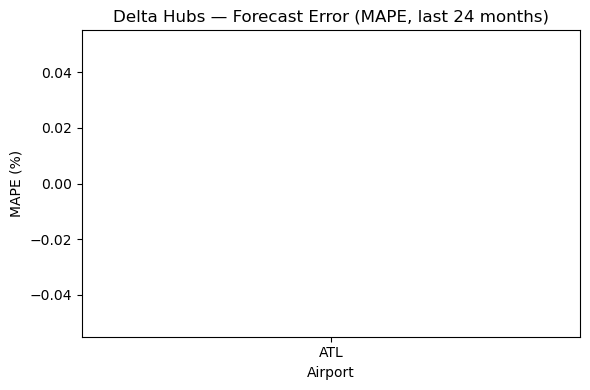

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\comparative\delta_hubs_mape_comparison.png


In [22]:
plt.figure(figsize=(6,4))
plt.bar(metrics_pretty.index, metrics_pretty["mape"])
plt.title("Delta Hubs — Forecast Error (MAPE, last 24 months)")
plt.ylabel("MAPE (%)")
plt.xlabel("Airport")
plt.tight_layout()

out_path = IMAGES_DIR / "delta_hubs_mape_comparison.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


In [23]:
metrics_df


,airport,mae,rmse,mape,last_hist_pax,forecast_last_pax,forecast_growth_abs,forecast_growth_pct
0,ATL,NaN,NaN,NaN,NaN,3.615350e+06,NaN,NaN
1,DTW,NaN,NaN,NaN,NaN,1.008403e+06,NaN,NaN
2,MSP,NaN,NaN,NaN,NaN,1.022539e+06,NaN,NaN


In [24]:
def evaluate_hub(airport_code: str, test_horizon: int = 24):
    """
    Load cleaned Delta data for a hub, compute:
      - Prophet backtest metrics (MAE, RMSE, MAPE) on last `test_horizon` months
      - Last observed passengers
      - Last forecast passengers 3 years ahead
      - Absolute and % growth
    Returns:
      metrics dict, full forecast DataFrame, merged (history + yhat) DataFrame
    """
    path = OUTPUT_DIR / f"delta_{airport_code.lower()}.csv"
    print(f"\n=== {airport_code} ===")
    print("Loading:", path)

    df = pd.read_csv(path)
    df.columns = [c.lower() for c in df.columns]

    # Basic prep
    df["date"] = pd.to_datetime(df["date"])
    df["pax"] = df["passengers_domestic"] + df["passengers_international"]

    # Drop rows with missing pax (this was causing NaNs in metrics)
    df = df.dropna(subset=["pax"])
    df = df.sort_values("date").reset_index(drop=True)

    # Prepare Prophet dataframe
    df_prophet = df[["date", "pax"]].rename(columns={"date": "ds", "pax": "y"})
    df_prophet = df_prophet.sort_values("ds").reset_index(drop=True)

    # Make sure we have enough data for the chosen horizon
    if len(df_prophet) <= test_horizon + 12:
        print(f"Warning: not much history for {airport_code} vs test horizon {test_horizon}")

    # ---- Train / Test split ----
    split_idx = len(df_prophet) - test_horizon
    train_df = df_prophet.iloc[:split_idx].copy()
    test_df  = df_prophet.iloc[split_idx:].copy()

    print("Train:", train_df["ds"].min().date(), "→", train_df["ds"].max().date(), "| n =", len(train_df))
    print("Test :", test_df["ds"].min().date(),  "→", test_df["ds"].max().date(),  "| n =", len(test_df))

    # ---- Fit Prophet on train ----
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    # Drop any NaNs in training (safety)
    m.fit(train_df.dropna(subset=["y"]))

    # Forecast over full period (train + test)
    future = m.make_future_dataframe(periods=test_horizon, freq="MS")
    forecast = m.predict(future)

    # Merge actual & predicted
    merged_full = df_prophet.merge(forecast[["ds", "yhat"]], on="ds", how="left")

    # Extract test portion for metrics
    test_merged = merged_full.iloc[split_idx:].copy()

    # Drop rows where either side is NaN before metrics
    test_clean = test_merged.dropna(subset=["y", "yhat"])
    if len(test_clean) == 0:
        print(f"Warning: no overlapping non-NaN data for metrics at {airport_code}")
        mae = rmse = mape = np.nan
    else:
        y_true = test_clean["y"].values
        y_pred = test_clean["yhat"].values

        mae  = np.mean(np.abs(y_true - y_pred))
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        mape = np.mean(np.abs(y_true - y_pred) / y_true) * 100

    # ---- Refit on full data for


In [25]:
def evaluate_hub(airport_code: str, test_horizon: int = 24):
    """
    Load cleaned Delta data for a hub, compute:
      - Prophet backtest metrics (MAE, RMSE, MAPE) on last `test_horizon` months
      - Last observed passengers
      - Last forecast passengers 3 years ahead
      - Absolute and % growth
    Returns:
      metrics dict, full forecast DataFrame, merged (history + yhat) DataFrame
    """
    path = OUTPUT_DIR / f"delta_{airport_code.lower()}.csv"
    print(f"\n=== {airport_code} ===")
    print("Loading:", path)

    df = pd.read_csv(path)
    df.columns = [c.lower() for c in df.columns]

    # Basic prep
    df["date"] = pd.to_datetime(df["date"])
    df["pax"] = df["passengers_domestic"] + df["passengers_international"]

    # Drop rows with missing pax (this was causing NaNs in metrics)
    df = df.dropna(subset=["pax"])
    df = df.sort_values("date").reset_index(drop=True)

    # Prepare Prophet dataframe
    df_prophet = df[["date", "pax"]].rename(columns={"date": "ds", "pax": "y"})
    df_prophet = df_prophet.sort_values("ds").reset_index(drop=True)

    # Make sure we have enough data for the chosen horizon
    if len(df_prophet) <= test_horizon + 12:
        print(f"Warning: not much history for {airport_code} vs test horizon {test_horizon}")

    # ---- Train / Test split ----
    split_idx = len(df_prophet) - test_horizon
    train_df = df_prophet.iloc[:split_idx].copy()
    test_df  = df_prophet.iloc[split_idx:].copy()

    print("Train:", train_df["ds"].min().date(), "→", train_df["ds"].max().date(), "| n =", len(train_df))
    print("Test :", test_df["ds"].min().date(),  "→", test_df["ds"].max().date(),  "| n =", len(test_df))

    # ---- Fit Prophet on train ----
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    # Drop any NaNs in training (safety)
    m.fit(train_df.dropna(subset=["y"]))

    # Forecast over full period (train + test)
    future = m.make_future_dataframe(periods=test_horizon, freq="MS")
    forecast = m.predict(future)

    # Merge actual & predicted
    merged_full = df_prophet.merge(forecast[["ds", "yhat"]], on="ds", how="left")

    # Extract test portion for metrics
    test_merged = merged_full.iloc[split_idx:].copy()

    # Drop rows where either side is NaN before metrics
    test_clean = test_merged.dropna(subset=["y", "yhat"])
    if len(test_clean) == 0:
        print(f"Warning: no overlapping non-NaN data for metrics at {airport_code}")
        mae = rmse = mape = np.nan
    else:
        y_true = test_clean["y"].values
        y_pred = test_clean["yhat"].values

        mae  = np.mean(np.abs(y_true - y_pred))
        rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
        mape = np.mean(np.abs(y_true - y_pred) / y_true) * 100

    # ---- Refit on full data for 3-year forecast ----
    m_full = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m_full.fit(df_prophet.dropna(subset=["y"]))

    future_full   = m_full.make_future_dataframe(periods=36, freq="MS")
    forecast_full = m_full.predict(future_full)
    forecast_full["airport"] = airport_code

    # Last non-NaN historical passenger value
    if df_prophet["y"].notna().any():
        last_hist = df_prophet["y"].dropna().iloc[-1]
    else:
        last_hist = np.nan

    last_fore = forecast_full["yhat"].iloc[-1]
    if np.isnan(last_hist):
        growth_abs = np.nan
        growth_pct = np.nan
    else:
        growth_abs = last_fore - last_hist
        growth_pct = (growth_abs / last_hist) * 100

    metrics = {
        "airport": airport_code,
        "mae": mae,
        "rmse": rmse,
        "mape": mape,
        "last_hist_pax": last_hist,
        "forecast_last_pax": last_fore,
        "forecast_growth_abs": growth_abs,
        "forecast_growth_pct": growth_pct,
    }

    return metrics, forecast_full, merged_full


In [26]:
airports = ["ATL", "DTW", "MSP"]

metrics_list = []
forecast_list = []
merged_hist_list = []

for ap in airports:
    mtr, fcst_full, merged_full = evaluate_hub(ap, test_horizon=24)
    metrics_list.append(mtr)
    forecast_list.append(fcst_full)
    merged_hist_list.append(merged_full)

metrics_df = pd.DataFrame(metrics_list)
metrics_df


13:34:46 - cmdstanpy - INFO - Chain [1] start processing
13:34:46 - cmdstanpy - INFO - Chain [1] done processing



=== ATL ===
Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_atl.csv
Train: 2002-10-01 → 2014-12-01 | n = 147
Test : 2015-01-01 → 2016-12-01 | n = 24


13:34:46 - cmdstanpy - INFO - Chain [1] start processing
13:34:46 - cmdstanpy - INFO - Chain [1] done processing
13:34:46 - cmdstanpy - INFO - Chain [1] start processing



=== DTW ===
Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_dtw.csv
Train: 2002-12-01 → 2014-12-01 | n = 94
Test : 2015-01-01 → 2016-12-01 | n = 24


13:34:47 - cmdstanpy - INFO - Chain [1] done processing
13:34:47 - cmdstanpy - INFO - Chain [1] start processing
13:34:47 - cmdstanpy - INFO - Chain [1] done processing
13:34:47 - cmdstanpy - INFO - Chain [1] start processing



=== MSP ===
Loading: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\clean\delta_msp.csv
Train: 2006-11-01 → 2014-12-01 | n = 74
Test : 2015-01-01 → 2016-12-01 | n = 24


13:34:47 - cmdstanpy - INFO - Chain [1] done processing
13:34:47 - cmdstanpy - INFO - Chain [1] start processing
13:34:48 - cmdstanpy - INFO - Chain [1] done processing


,airport,mae,rmse,mape,last_hist_pax,forecast_last_pax,forecast_growth_abs,forecast_growth_pct
0,ATL,111968.184901,130513.998104,3.715702,2973292.0,3.615350e+06,642057.901940,21.594176
1,DTW,169938.967550,187675.403338,25.613789,652549.0,1.008403e+06,355853.796911,54.532885
2,MSP,185372.774409,192703.551357,24.970694,691840.0,1.022539e+06,330698.622580,47.799870


In [27]:
import numpy as np

metrics_pretty = metrics_df.copy()

# Replace +/- inf with NaN, just in case
metrics_pretty = metrics_pretty.replace([np.inf, -np.inf], np.nan)

# Round but keep as float (no int cast)
metrics_pretty["mae"]  = metrics_pretty["mae"].round(0)
metrics_pretty["rmse"] = metrics_pretty["rmse"].round(0)
metrics_pretty["mape"] = metrics_pretty["mape"].round(2)

metrics_pretty["last_hist_pax"]       = metrics_pretty["last_hist_pax"].round(0)
metrics_pretty["forecast_last_pax"]   = metrics_pretty["forecast_last_pax"].round(0)
metrics_pretty["forecast_growth_abs"] = metrics_pretty["forecast_growth_abs"].round(0)
metrics_pretty["forecast_growth_pct"] = metrics_pretty["forecast_growth_pct"].round(2)

metrics_pretty = metrics_pretty.set_index("airport").sort_index()

metrics_pretty


,mae,rmse,mape,last_hist_pax,forecast_last_pax,forecast_growth_abs,forecast_growth_pct
airport,,,,,,,
ATL,111968.0,130514.0,3.72,2973292.0,3615350.0,642058.0,21.59
DTW,169939.0,187675.0,25.61,652549.0,1008403.0,355854.0,54.53
MSP,185373.0,192704.0,24.97,691840.0,1022539.0,330699.0,47.80


In [28]:
out_csv = SUMMARY_OUTDIR / "delta_hubs_backtest_and_forecast_summary.csv"
metrics_pretty.to_csv(out_csv)
print("Saved metrics summary to:", out_csv)


Saved metrics summary to: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\output\summary\delta_hubs_backtest_and_forecast_summary.csv


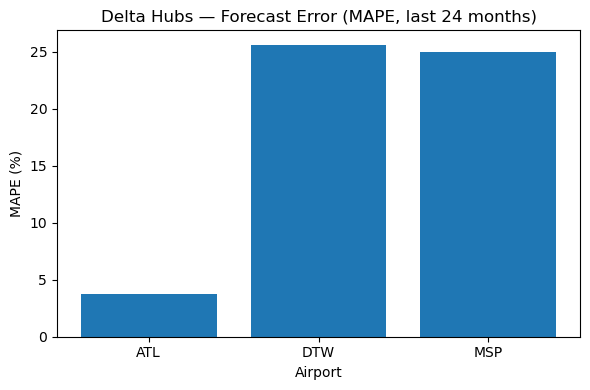

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\comparative\delta_hubs_mape_comparison.png


In [29]:
plt.figure(figsize=(6,4))
plt.bar(metrics_pretty.index, metrics_pretty["mape"])
plt.title("Delta Hubs — Forecast Error (MAPE, last 24 months)")
plt.ylabel("MAPE (%)")
plt.xlabel("Airport")
plt.tight_layout()

out_path = IMAGES_DIR / "delta_hubs_mape_comparison.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


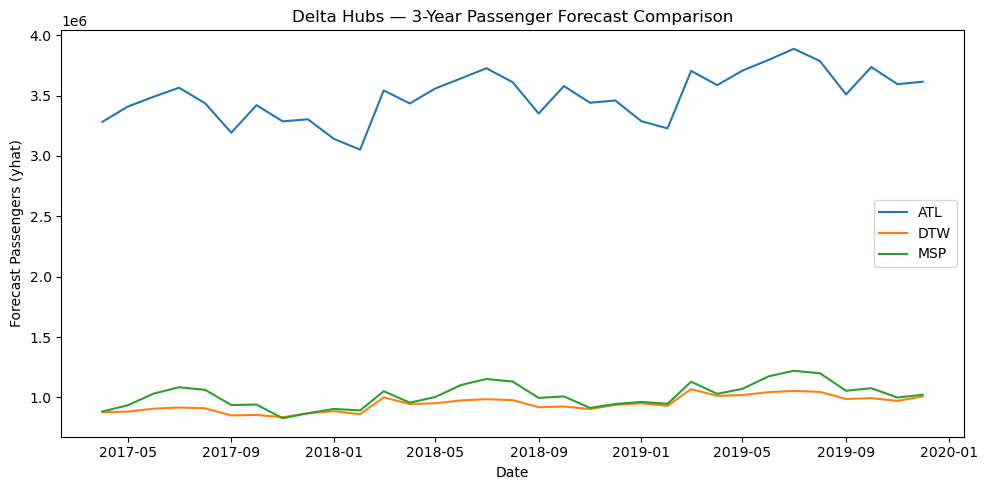

Saved: C:\Users\Seb\Documents\Portfolio (Projects)\Aviation_AI_Projects\Project_B_Delta_Airlines_Demand_Forecasting\images\comparative\delta_hubs_3year_forecast_comparison.png


In [30]:
# restrict to future period only
latest_hist_date = max(df["date"].max() for df in [pd.read_csv(OUTPUT_DIR / f"delta_{a.lower()}.csv") for a in airports])
latest_hist_date = pd.to_datetime(latest_hist_date)

future_only = forecast_df[forecast_df["ds"] > latest_hist_date].copy()

plt.figure(figsize=(10,5))

for ap in airports:
    dfa = future_only[future_only["airport"] == ap]
    plt.plot(dfa["ds"], dfa["yhat"], label=ap)

plt.title("Delta Hubs — 3-Year Passenger Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Forecast Passengers (yhat)")
plt.legend()
plt.tight_layout()

out_path = IMAGES_DIR / "delta_hubs_3year_forecast_comparison.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


In [31]:
for ap, row in metrics_pretty.iterrows():
    print(f"\n{ap}:")
    print(f"  MAPE (24m): {row['mape']:.2f}%")
    print(f"  Last observed pax: {row['last_hist_pax']:,}")
    print(f"  Forecast last pax (3y ahead): {row['forecast_last_pax']:,}")
    print(f"  Growth over horizon: {row['forecast_growth_abs']:,} ({row['forecast_growth_pct']:.2f}%)")



ATL:
  MAPE (24m): 3.72%
  Last observed pax: 2,973,292.0
  Forecast last pax (3y ahead): 3,615,350.0
  Growth over horizon: 642,058.0 (21.59%)

DTW:
  MAPE (24m): 25.61%
  Last observed pax: 652,549.0
  Forecast last pax (3y ahead): 1,008,403.0
  Growth over horizon: 355,854.0 (54.53%)

MSP:
  MAPE (24m): 24.97%
  Last observed pax: 691,840.0
  Forecast last pax (3y ahead): 1,022,539.0
  Growth over horizon: 330,699.0 (47.80%)


In [32]:
metrics_df

,airport,mae,rmse,mape,last_hist_pax,forecast_last_pax,forecast_growth_abs,forecast_growth_pct
0,ATL,111968.184901,130513.998104,3.715702,2973292.0,3.615350e+06,642057.901940,21.594176
1,DTW,169938.967550,187675.403338,25.613789,652549.0,1.008403e+06,355853.796911,54.532885
2,MSP,185372.774409,192703.551357,24.970694,691840.0,1.022539e+06,330698.622580,47.799870
